## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gymnasium as gym
from diffuser.utils.config import Config
import os
import collections
import numpy as np
import pdb
from minari import DataCollector, StepDataCallback

c:\Users\Beste Aydemir\AppData\Local\pypoetry\Cache\virtualenvs\adlr-uQXv-DS1-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Diffuser Lib

In [3]:
class Args:
    def __init__(
        self,
        loader,
        savepath,
        dataset,
        horizon,
        normalizer,
        preprocess_fns,
        use_padding,
        max_path_length,
        renderer,
        model,
        dim_mults,
        device,
    ):
        self.loader = loader
        self.savepath = savepath
        self.dataset = dataset
        self.horizon = horizon
        self.normalizer = normalizer
        self.preprocess_fns = preprocess_fns
        self.use_padding = use_padding
        self.max_path_length = max_path_length
        self.renderer = renderer
        self.model = model
        # self.transition_dim=transition_dim
        # self.cond_dim=cond_dim
        self.dim_mults = dim_mults
        self.device = device


args = Args(
    loader="datasets.sequence.GoalDataset",
    savepath="saved/",
    dataset="",
    horizon=256,
    normalizer="LimitsNormalizer",
    preprocess_fns=["maze2d_set_terminals"],
    use_padding=False,
    max_path_length=10000,
    renderer="utils.rendering.Maze2dRenderer",
    model="models.temporal.TemporalUnet",
    dim_mults=(1, 4, 8),
    device="cpu",
)

In [4]:
dataset_config = Config(
    args.loader,
    savepath=(args.savepath, "dataset_config.pkl"),
    env="PointMaze_Medium-v3",
    horizon=args.horizon,
    normalizer=args.normalizer,
    preprocess_fns=args.preprocess_fns,
    use_padding=args.use_padding,
    max_path_length=args.max_path_length,
)

_class:datasets.sequence.GoalDataset
[ utils/config ] Imported diffuser.datasets.sequence:GoalDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.GoalDataset'>
    env: PointMaze_Medium-v3
    horizon: 256
    max_path_length: 10000
    normalizer: LimitsNormalizer
    preprocess_fns: ['maze2d_set_terminals']
    use_padding: False

[ utils/config ] Saved config to: saved/dataset_config.pkl



In [6]:
from minari import DataCollector, list_local_datasets, load_dataset, delete_dataset
for dataset_name in list_local_datasets():
    print(dataset_name)
    #delete_dataset(dataset_name)


C:\Users\Beste Aydemir\.minari\datasets\pointmaze-medium-v2\data
pointmaze-medium-v2
pointmaze-medium-v2


In [7]:
dataset = dataset_config()

Name of the enviornment: PointMaze_Medium-v3
Name of the enviornment: PointMaze_Medium-v3
Dataset_name:pointmaze-medium-v2
C:\Users\Beste Aydemir\.minari\datasets\pointmaze-medium-v2\data
pointmaze-medium-v2
dataset exists!
328
[ datasets/buffer ] Finalized replay buffer | 4752 episodes
[ datasets/buffer ] Fields:
    achieved_goal: (4752, 10000, 2)
    desired_goal: (4752, 10000, 2)
    observations: (4752, 10000, 4)
    observation: (4752, 10000, 4)
    next_observations: (4752, 10000, 4)
    actions: (4752, 10000, 2)
    terminals: (4752, 10000, 1)
    timeouts: (4752, 10000, 1)
[ datasets/buffer ] Fields:
    achieved_goal: (4752, 10000, 2)
    desired_goal: (4752, 10000, 2)
    observations: (4752, 10000, 4)
    observation: (4752, 10000, 4)
    next_observations: (4752, 10000, 4)
    actions: (4752, 10000, 2)
    terminals: (4752, 10000, 1)
    timeouts: (4752, 10000, 1)
    normed_observations: (4752, 10000, 4)
    normed_actions: (4752, 10000, 2)


## Configs for Rendering and the model

In [8]:
render_config = Config(
    args.renderer,
    savepath=(args.savepath, "render_config.pkl"),
    env="PointMaze_Medium-v3",
)

_class:utils.rendering.Maze2dRenderer
[ utils/config ] Imported diffuser.utils.rendering:Maze2dRenderer

[utils/config ] Config: <class 'diffuser.utils.rendering.Maze2dRenderer'>
    env: PointMaze_Medium-v3

[ utils/config ] Saved config to: saved/render_config.pkl



In [9]:
# observation_dim = dataset.observation_dim
# action_dim = dataset.action_dim
observation_dim = 4
action_dim = 2
# -----------------------------------------------------------------------------#
# ------------------------------ model & trainer ------------------------------#
# -----------------------------------------------------------------------------#

model_config = Config(
    args.model,
    savepath=(args.savepath, "model_config.pkl"),
    horizon=args.horizon,
    transition_dim=observation_dim + action_dim,
    cond_dim=observation_dim,
    dim_mults=args.dim_mults,
    device=args.device,
)

_class:models.temporal.TemporalUnet
[ utils/config ] Imported diffuser.models.temporal:TemporalUnet

[utils/config ] Config: <class 'diffuser.models.temporal.TemporalUnet'>
    cond_dim: 4
    dim_mults: (1, 4, 8)
    horizon: 256
    transition_dim: 6

[ utils/config ] Saved config to: saved/model_config.pkl



In [10]:
renderer = render_config()

Name of the enviornment: PointMaze_Medium-v3
[[0 0]]
[-2.52096393  2.32878383]


In [11]:
model = model_config()

[ models/temporal ] Channel dimensions: [(6, 32), (32, 128), (128, 256)]
[(6, 32), (32, 128), (128, 256)]


In [12]:
diffusion_config = Config(
    _class="models.diffuser.GaussianDiffusion",
    savepath=(args.savepath, "diffusion_config.pkl"),
    horizon=256,
    observation_dim=observation_dim,
    action_dim=2,
    n_timesteps=256,
    loss_type="l2",
    clip_denoised=True,
    predict_epsilon=False,
    # loss weighting
    action_weight=1,
    loss_weights=None,
    loss_discount=1,
    device=args.device,
)

_class:models.diffuser.GaussianDiffusion
[ utils/config ] Imported diffuser.models.diffuser:GaussianDiffusion

[utils/config ] Config: <class 'diffuser.models.diffuser.GaussianDiffusion'>
    action_dim: 2
    action_weight: 1
    clip_denoised: True
    horizon: 256
    loss_discount: 1
    loss_type: l2
    loss_weights: None
    n_timesteps: 256
    observation_dim: 4
    predict_epsilon: False

[ utils/config ] Saved config to: saved/diffusion_config.pkl



In [13]:
diffuser = diffusion_config(model)

## Forward pass is working

In [14]:
from diffuser.utils.arrays import report_parameters, batchify

report_parameters(model)

print("Testing forward...", end=" ", flush=True)
batch = batchify(dataset[0])
loss, _ = diffuser.loss(*batch)
loss.backward()
print("✓")

[ utils/arrays ] Total parameters: 3.68 M
         downs.2.0.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         downs.2.1.blocks.0.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         downs.2.1.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         ups.0.0.blocks.0.block.0.weight: 327.68 k | Conv1d(512, 128, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block1.blocks.0.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block1.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block2.blocks.0.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         mid_block2.blocks.1.block.0.weight: 327.68 k | Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
         downs.2.0.b

## Using the trainer requires taking care of the 'device' in the folders

In [15]:
from diffuser.utils.training import Trainer

trainer_config = Config(
    Trainer,
    savepath=(args.savepath, "trainer_config.pkl"),
    train_batch_size=32,
    train_lr=2e-4,
    gradient_accumulate_every=2,
    ema_decay=0.005,
    sample_freq=20,
    save_freq=50,
    label_freq=int(2e4 // 50),
    save_parallel=False,
    results_folder=args.savepath,
    bucket=None,
    n_reference=1,
    n_samples=1,
)


[utils/config ] Config: <class 'diffuser.utils.training.Trainer'>
    bucket: None
    ema_decay: 0.005
    gradient_accumulate_every: 2
    label_freq: 400
    n_reference: 1
    n_samples: 1
    results_folder: saved/
    sample_freq: 20
    save_freq: 50
    save_parallel: False
    train_batch_size: 32
    train_lr: 0.0002

[ utils/config ] Saved config to: saved/trainer_config.pkl



In [16]:
trainer = trainer_config(diffuser, dataset, renderer)

# Training process inlcluding rendering

In [17]:
import torch

torch.cuda.is_available()

False

Epoch 0 / 1 | saved/
[ utils/training ] Saved model to saved/state_0.pt
0:   0.2858 | a0_loss:   0.7336 | t:   3.1469
(1, 256, 4)
1
The last observation [-1.6565202  1.5349927  0.5964222  3.7868156]


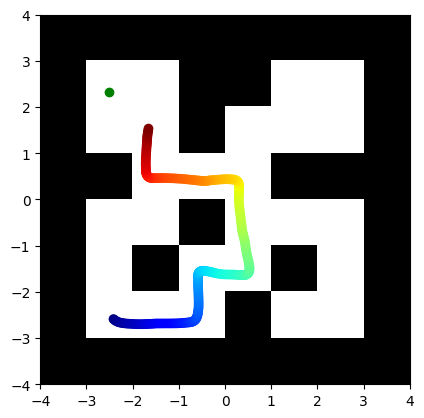

Saved 1 samples to: saved/_sample-reference.png
Step: 0 - Rendering samples
(1, 257, 4)
1
The last observation [0.42935467 0.49666142 2.2532082  0.5126629 ]


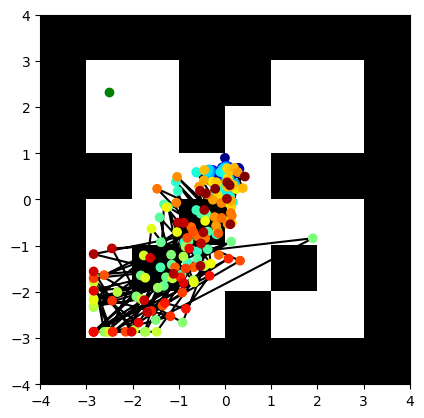

Saved 1 samples to: saved/sample-0-0.png
(1, 257, 4)
1
The last observation [-2.687817   -1.8945738   0.16294289  3.966507  ]


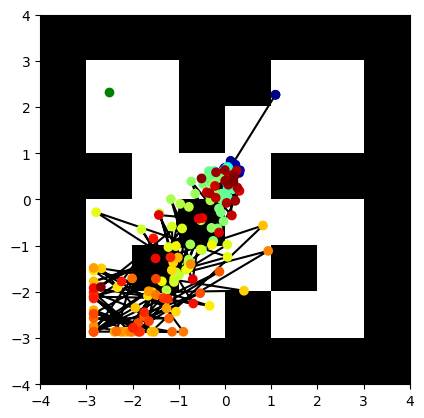

Saved 1 samples to: saved/sample-0-1.png
Step: 20 - Rendering samples
(1, 257, 4)
1
The last observation [-2.6466184  -2.0371737   0.59283733  4.591213  ]


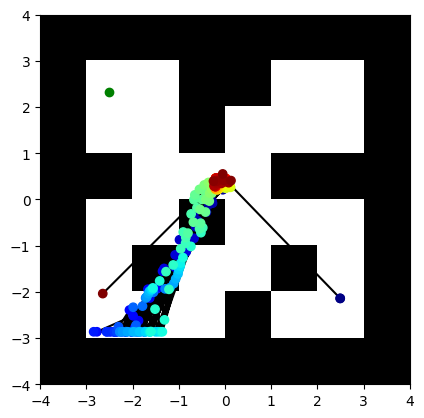

Saved 1 samples to: saved/sample-20-0.png
(1, 257, 4)
1
The last observation [-0.4281404  -1.4125222   2.5779953   0.15802193]


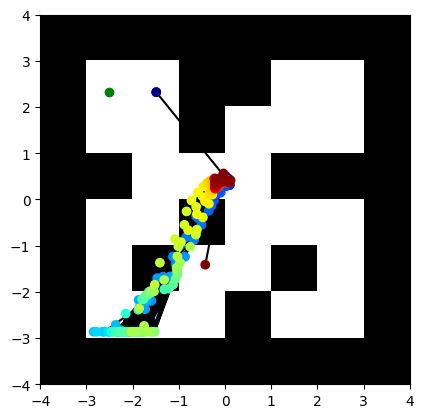

Saved 1 samples to: saved/sample-20-1.png


In [18]:
# n_epochs = int(args.n_train_steps // args.n_steps_per_epoch)
n_epochs = 1
for i in range(n_epochs):
    print(f"Epoch {i} / {n_epochs} | {args.savepath}")
    trainer.train(n_train_steps=40)

## Plotting Dataset (dont run)

In [ ]:
import gymnasium as gym

In [ ]:
env = gym.make("PointMaze_Medium-v3")
background = env.maze.maze_map

background_array = np.array(background)
rows, cols = background_array.shape

# Define the extent to center the plot at (0, 0)
extent = [-cols/2, cols/2, -rows/2, rows/2]

plt.clf()
fig = plt.gcf()
#fig.set_size_inches(5, 5)
plt.imshow(
    np.array((background)),
    cmap=plt.cm.binary,
    extent = extent,
    # vmax=1,
)

path_length = len(all_observations)
#observations = observations.reshape(len(observations), -1)
colors = plt.cm.jet(np.linspace(0, 1, path_length))
plt.plot(all_observations[:, 0], all_observations[:, 1], c="black", zorder=10)
plt.scatter(all_observations[:, 0], all_observations[:, 1], c=colors, zorder=20)

In [ ]:
observations = ds[0].observations["observation"]

In [ ]:
ds[0].terminations.sum()

In [ ]:
len(observations)

In [ ]:
ds[0].observations["desired_goal"]

In [ ]:
import numpy as np

# Initialize an empty numpy array with two dimensions
all_observations = np.empty((0, data[0].observations["observation"].shape[1]))

# Loop over the dataset
for i in range(len(data) // 100):
    # Append the observations to the numpy array
    all_observations = np.append(all_observations, data[i].observations["observation"], axis=0)

# Print the final length of the accumulated observations
print(len(all_observations))

## Random Test (don't run)

In [ ]:
from minari import DataCollector, list_local_datasets, load_dataset, delete_dataset
for dataset_name in list_local_datasets():
    print(dataset_name)
    delete_dataset(dataset_name)

In [ ]:
import minari
ddss = minari.download_dataset("pointmaze-medium-v2")

In [ ]:
data = load_dataset("pointmaze-medium-v2")

In [ ]:
data._data.total_episodes

In [ ]:

data[0].observations["observation"]

In [ ]:
from contextlib import (
    contextmanager,
    redirect_stderr,
    redirect_stdout,
)


@contextmanager
def suppress_output():
    """
    A context manager that redirects stdout and stderr to devnull
    https://stackoverflow.com/a/52442331
    """
    with open(os.devnull, "w") as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)


# with suppress_output():
#     ## d4rl prints out a variety of warnings
#     import d4rl

# -----------------------------------------------------------------------------#
# -------------------------------- general api --------------------------------#
# -----------------------------------------------------------------------------#


def load_environment(name):
    print(name)
    if type(name) != str:
        # name is already an environment
        return name
    with suppress_output():
        wrapped_env = gym.make(name)
    env = wrapped_env.unwrapped
    env.max_episode_steps = wrapped_env._max_episode_steps
    env.name = name
    return env


class PointMazeStepDataCallback(StepDataCallback):
    """Add environment state information to 'infos'.

    Also, since the environment generates a new target every time it reaches a goal, the environment is
    never terminated or truncated. This callback overrides the truncation value to True when the step
    returns a True 'succes' key in 'infos'. This way we can divide the Minari dataset into different trajectories.
    """

    def __call__(
        self, env, obs, info, action=None, rew=None, terminated=None, truncated=None
    ):
        qpos = obs["observation"][:2]
        qvel = obs["observation"][2:]
        goal = obs["desired_goal"]

        step_data = super().__call__(env, obs, info, action, rew, terminated, truncated)

        if step_data["infos"]["success"]:
            step_data["truncation"] = True
        step_data["infos"]["qpos"] = qpos
        step_data["infos"]["qvel"] = qvel
        step_data["infos"]["goal"] = goal

        return step_data


UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3

EXPLORATION_ACTIONS = {UP: (0, 1), DOWN: (0, -1), LEFT: (-1, 0), RIGHT: (1, 0)}


class QIteration:
    """Solves for optimal policy with Q-Value Iteration.

    Inspired by https://github.com/Farama-Foundation/D4RL/blob/master/d4rl/pointmaze/q_iteration.py
    """

    def __init__(self, maze):
        self.maze = maze
        self.num_states = maze.map_length * maze.map_width
        self.num_actions = len(EXPLORATION_ACTIONS.keys())
        self.rew_matrix = np.zeros((self.num_states, self.num_actions))
        self.compute_transition_matrix()

    def generate_path(self, current_cell, goal_cell):
        self.compute_reward_matrix(goal_cell)
        q_values = self.get_q_values()
        current_state = self.cell_to_state(current_cell)
        waypoints = {}
        while True:
            action_id = np.argmax(q_values[current_state])
            next_state, _ = self.get_next_state(
                current_state, EXPLORATION_ACTIONS[action_id]
            )
            current_cell = self.state_to_cell(current_state)
            waypoints[current_cell] = self.state_to_cell(next_state)
            if waypoints[current_cell] == goal_cell:
                break

            current_state = next_state

        return waypoints

    def reward_function(self, desired_cell, current_cell):
        if desired_cell == current_cell:
            return 1.0
        else:
            return 0.0

    def state_to_cell(self, state):
        i = int(state / self.maze.map_width)
        j = state % self.maze.map_width
        return (i, j)

    def cell_to_state(self, cell):
        return cell[0] * self.maze.map_width + cell[1]

    def get_q_values(self, num_itrs=50, discount=0.99):
        q_fn = np.zeros((self.num_states, self.num_actions))
        for _ in range(num_itrs):
            v_fn = np.max(q_fn, axis=1)
            q_fn = self.rew_matrix + discount * self.transition_matrix.dot(v_fn)
        return q_fn

    def compute_reward_matrix(self, goal_cell):
        for state in range(self.num_states):
            for action in range(self.num_actions):
                next_state, _ = self.get_next_state(state, EXPLORATION_ACTIONS[action])
                next_cell = self.state_to_cell(next_state)
                self.rew_matrix[state, action] = self.reward_function(
                    goal_cell, next_cell
                )

    def compute_transition_matrix(self):
        """Constructs this environment's transition matrix.
        Returns:
          A dS x dA x dS array where the entry transition_matrix[s, a, ns]
          corresponds to the probability of transitioning into state ns after taking
          action a from state s.
        """
        self.transition_matrix = np.zeros(
            (self.num_states, self.num_actions, self.num_states)
        )
        for state in range(self.num_states):
            for action_idx, action in EXPLORATION_ACTIONS.items():
                next_state, valid = self.get_next_state(state, action)
                if valid:
                    self.transition_matrix[state, action_idx, next_state] = 1

    def get_next_state(self, state, action):
        cell = self.state_to_cell(state)

        next_cell = tuple(map(lambda i, j: int(i + j), cell, action))
        next_state = self.cell_to_state(next_cell)

        return next_state, self._check_valid_cell(next_cell)

    def _check_valid_cell(self, cell):
        # Out of map bounds
        if cell[0] >= self.maze.map_length:
            return False
        elif cell[1] >= self.maze.map_width:
            return False
        # Wall collision
        elif self.maze.maze_map[cell[0]][cell[1]] == 1:
            return False
        else:
            return True


class WaypointController:
    """Agent controller to follow waypoints in the maze.

    Inspired by https://github.com/Farama-Foundation/D4RL/blob/master/d4rl/pointmaze/waypoint_controller.py
    """

    def __init__(self, maze, gains={"p": 10.0, "d": -1.0}, waypoint_threshold=0.1):
        self.global_target_xy = np.empty(2)
        self.maze = maze

        self.maze_solver = QIteration(maze=self.maze)

        self.gains = gains
        self.waypoint_threshold = waypoint_threshold
        self.waypoint_targets = None

    def compute_action(self, obs):
        # Check if we need to generate new waypoint path due to change in global target
        if (
            np.linalg.norm(self.global_target_xy - obs["desired_goal"]) > 1e-3
            or self.waypoint_targets is None
        ):
            # Convert xy to cell id
            achieved_goal_cell = tuple(
                self.maze.cell_xy_to_rowcol(obs["achieved_goal"])
            )
            self.global_target_id = tuple(
                self.maze.cell_xy_to_rowcol(obs["desired_goal"])
            )
            self.global_target_xy = obs["desired_goal"]

            self.waypoint_targets = self.maze_solver.generate_path(
                achieved_goal_cell, self.global_target_id
            )

            # Check if the waypoint dictionary is empty
            # If empty then the ball is already in the target cell location
            if self.waypoint_targets:
                self.current_control_target_id = self.waypoint_targets[
                    achieved_goal_cell
                ]
                self.current_control_target_xy = self.maze.cell_rowcol_to_xy(
                    np.array(self.current_control_target_id)
                )
            else:
                self.waypoint_targets[self.current_control_target_id] = (
                    self.current_control_target_id
                )
                self.current_control_target_id = self.global_target_id
                self.current_control_target_xy = self.global_target_xy

        # Check if we need to go to the next waypoint
        dist = np.linalg.norm(self.current_control_target_xy - obs["achieved_goal"])
        if (
            dist <= self.waypoint_threshold
            and self.current_control_target_id != self.global_target_id
        ):
            self.current_control_target_id = self.waypoint_targets[
                self.current_control_target_id
            ]
            # If target is global goal go directly to goal position
            if self.current_control_target_id == self.global_target_id:
                self.current_control_target_xy = self.global_target_xy
            else:
                self.current_control_target_xy = (
                    self.maze.cell_rowcol_to_xy(
                        np.array(self.current_control_target_id)
                    )
                    - np.random.uniform(size=(2,)) * 0.2
                )

        action = (
            self.gains["p"] * (self.current_control_target_xy - obs["achieved_goal"])
            + self.gains["d"] * obs["observation"][2:]
        )
        action = np.clip(action, -1, 1)

        return action


def get_dataset():
    # Code from Minari documentation
    dataset_name = "pointmaze-umaze-v0"
    total_steps = 20000

    # continuing task => the episode doesn't terminate or truncate when reaching a goal
    # it will generate a new target. For this reason we set the maximum episode steps to
    # the desired size of our Minari dataset (evade truncation due to time limit)
    env = gym.make(
        "PointMaze_Medium-v3", continuing_task=True, max_episode_steps=total_steps // 2
    )

    # Data collector wrapper to save temporary data while stepping. Characteristics:
    #   * Custom StepDataCallback to add extra state information to 'infos' and divide dataset in different episodes by overridng
    #     truncation value to True when target is reached
    #   * Record the 'info' value of every step
    collector_env = DataCollector(
        env, step_data_callback=PointMazeStepDataCallback, record_infos=True
    )

    obs, _ = collector_env.reset(seed=123)

    waypoint_controller = WaypointController(maze=env.maze)

    for n_step in range(int(total_steps)):
        action = waypoint_controller.compute_action(obs)
        # Add some noise to each step action
        action += np.random.randn(*action.shape) * 0.5
        action = np.clip(
            action, env.action_space.low, env.action_space.high, dtype=np.float32
        )

        obs, rew, terminated, truncated, info = collector_env.step(action)

    dataset = collector_env.create_dataset(
        dataset_id=dataset_name,
        algorithm_name="QIteration",
        code_permalink="https://github.com/Farama-Foundation/Minari/blob/main/docs/tutorials/dataset_creation/point_maze_dataset.py",
        author="Rodrigo Perez-Vicente",
        author_email="rperezvicente@farama.org",
    )
    return dataset


dataset = get_dataset()

In [ ]:
10000// 10

In [ ]:
print(len(dataset))
for i in range(40):
    print(dataset[i].observations["observation"])


In [ ]:
reshaped = {}
for key, val in dataset.items():
    dim = val.shape[-1]
    reshaped[key] = val.reshape(-1, dim)

In [ ]:
def process_maze2d_episode(episode):
    '''
        adds in `next_observations` field to episode
    '''
    #assert 'next_observations' not in episode
    ep = {}
    length = len(episode.observations)
    next_observations = episode.observations["observation"][1:].copy()
    for key, val in episode.observations.items():
        ep[key] = val[:-1]
    ep['next_observations'] = next_observations
    for attr, value in vars(episode).items():
      if attr == "observations":
        continue
      elif attr == "terminations":
        ep["terminals"] = value
      elif attr == "truncations":
        ep["timeouts"] = value
      elif attr == "id" or attr == "seed" or attr == "total_timesteps" or "infos"
        continue
      else:
        ep[attr] = value

    return ep

In [ ]:
a = process_maze2d_episode(dataset[0])

In [ ]:
print(a.keys())

In [ ]:
a["terminals"].any()

In [ ]:
dataset[0].infos["goal"].shape

In [ ]:
for attr, value in vars(dataset[0]).items():
    if attr == "observations":
        continue
    print(f"{attr}: {value}")

In [ ]:
# dataset = get_dataset()
# dataset = preprocess_fn(dataset)

# N = dataset['rewards'].shape[0]
N = dataset[0].rewards.shape[0]
# N = dataset._data.total_episodes
data_ = collections.defaultdict(list)

# The newer version of the dataset adds an explicit
# timeouts field. Keep old method for backwards compatability.
use_timeouts = False
print(N)
episode_step = 0
for i in range(N):
    # print(dataset[i])
    # dataset[i].observations
    # done_bool = bool(dataset['terminals'][i])
    done_bool = bool(dataset[episode_step].terminations[i])

    final_timestep = episode_step == env._max_episode_steps - 1

    # for k in dataset:
    for attr, value in vars(dataset[episode_step]).items():
        # if 'metadata' in k: continue
        # data_[k].append(dataset[k][i])
        data_[attr].append(value)

    if done_bool or final_timestep:
        episode_step = 0
        episode_data = {}
        for k in data_:
            episode_data[k] = np.array(data_[k])
        episode_data = process_maze2d_episode(dataset[i])
        print(episode_data)
        data_ = collections.defaultdict(list)

        episode_step += 1
    break